# Example 5 - Unified AGM

## Objective
In this notebook, we compare three optimization algorithms:
1. **AGM-C**: Designed for convex functions ($\mu = 0$).
2. **AGM-SC**: Designed for strongly convex functions ($\mu > 0$).
3. **Unified AGM**: Generalized approach for both convex and strongly convex functions.

## Problem Setup
We optimize the following quadratic function:  
$$f(x) = \frac{1}{2} x^T Q x,$$  
where $Q$ is a positive definite matrix with eigenvalues in the range $[\mu, L]$.

### Parameters
- Dimension: $n = 1000$
- Lipschitz constant: $L = 1.0$
- Strong convexity constants: $\mu = \{ 0.01, 0.001, 0.0001 \}$
- Number of iterations: $300$
- Step size: $s = \frac{1}{L}$

## Algorithms
### AGM-C (Convex Case)
$$
y_k = x_k + \frac{2}{k+1} (z_k - x_k)  
$$
$$
x_{k+1} = y_k - s \nabla f(y_k)  
$$
$$
z_{k+1} = z_k - \frac{s(k+1)}{2} \nabla f(y_k)  
$$

### AGM-SC (Strongly Convex Case)
$$
y_k = x_k + \frac{\sqrt{\mu s}}{1 + \sqrt{\mu s}} (z_k - x_k)  
$$
$$
x_{k+1} = y_k - s \nabla f(y_k)  
$$
$$
z_{k+1} = z_k + \sqrt{\mu s} \left( y_k - z_k - \frac{1}{\mu} \nabla f(y_k) \right)  
$$

### Unified AGM
$$
y_k = x_k + \frac{1}{1-q} \left( \frac{2}{\iota (k+1)} \text{cothc}\left( \frac{(k+1)\iota \sqrt{q}}{2} \right) - q \right) (z_k - x_k)  
$$
$$
x_{k+1} = y_k - s \nabla f(y_k)  
$$
$$
z_{k+1} = z_k + \frac{\iota s (k+1)}{2} \text{tanhc}\left( \frac{(k+1)\iota \sqrt{q}}{2} \right) \left( \mu y_k - \mu z_k - \nabla f(y_k) \right)  
$$

Here, $q = \mu s$ and $\iota = -\frac{\log(1 - \sqrt{q})}{\sqrt{q}}$.

## Results
The graphs below show $f(x_k) - f^*$ (log scale) for each algorithm across 300 iterations. Each graph corresponds to a different $\mu$ value.

## Reference
- Kim, J., & Yang, I. (2023). "Unifying Nesterov’s Accelerated Gradient Methods for Convex and Strongly Convex Objective Functions." *Proceedings of the 40th International Conference on Machine Learning*, 202:16897-16954. Available at: https://proceedings.mlr.press/v202/kim23y.html


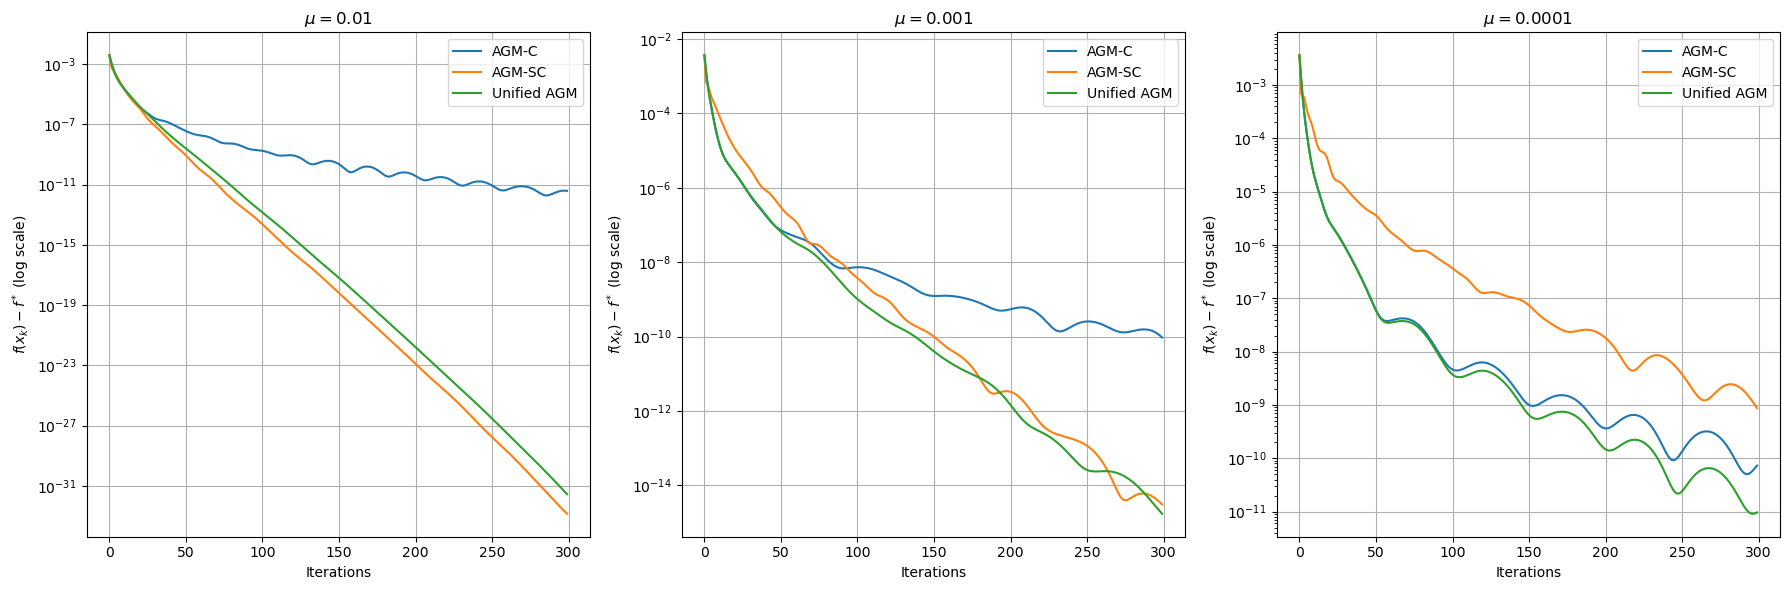

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Helper functions
def cothc(x):
    return np.where(x != 0, x / np.tanh(x), 1)

def tanhc(x):
    return np.where(x != 0, np.tanh(x) / x, 1)

def quadratic_function(Q, x):
    return 0.5 * x.T @ Q @ x

def grad_quadratic(Q, x):
    return Q @ x

def generate_Q(n, mu, L):
    eigenvalues = np.random.uniform(mu, L, n)
    Q = np.diag(eigenvalues)
    V = np.linalg.qr(np.random.randn(n, n))[0]
    return V.T @ Q @ V

# AGM-C implementation
def run_AGM_C(Q, x0, num_iterations, s):
    x_k = x0
    z_k = x0
    function_values = []
    
    for k in range(1, num_iterations + 1):
        y_k = x_k + (2 / (k + 1)) * (z_k - x_k)  # Update y_k
        gradient = grad_quadratic(Q, y_k)
        x_k = y_k - s * gradient  # Update x_k
        z_k = z_k - (s * (k + 1) / 2) * gradient  # Update z_k
        function_values.append(quadratic_function(Q, x_k))  # Track function value
    
    return function_values

# AGM-SC implementation
def run_AGM_SC(Q, x0, mu, num_iterations, s):
    x_k = x0
    z_k = x0
    function_values = []
    gamma = np.sqrt(mu * s) / (1 + np.sqrt(mu * s))  # Fixed acceleration factor
    
    for _ in range(num_iterations):
        y_k = x_k + gamma * (z_k - x_k)  # Update y_k
        gradient = grad_quadratic(Q, y_k)
        x_k = y_k - s * gradient  # Update x_k
        z_k = z_k + np.sqrt(mu * s) * (y_k - z_k - gradient / mu)  # Update z_k
        function_values.append(quadratic_function(Q, x_k))  # Track function value
    
    return function_values

# Unified AGM implementation
def run_Unified_AGM(Q, x0, mu, num_iterations, s):
    x_k = x0
    y_k = x0
    z_k = x0
    function_values = []

    for k in range(1, num_iterations + 1):
        q = mu * s
        iota = -np.log(1 - np.sqrt(q)) / np.sqrt(q) if q > 0 else 1  # Compute iota
        cothc_term = cothc((k + 1) * iota * np.sqrt(q) / 2)
        tanhc_term = tanhc((k + 1) * iota * np.sqrt(q) / 2)
        beta_k = (1 / (1 - q)) * ((2 / (iota * (k + 1))) * cothc_term - q)
        y_k = x_k + beta_k * (z_k - x_k)  # Update y_k
        gradient = grad_quadratic(Q, y_k)
        x_k = y_k - s * gradient  # Update x_k
        z_k = z_k + ((iota * s * (k + 1)) / 2) * tanhc_term * (mu * y_k - mu * z_k - gradient)  # Update z_k
        function_values.append(quadratic_function(Q, x_k))  # Track function value
    
    return function_values

# Problem setup
n = 1000
L = 1.0
mu_values = [0.01, 0.001, 0.0001]
num_iterations = 300
x0 = np.random.normal(0, 0.01, n)

# Generate Q matrices and run experiments
plt.figure(figsize=(18, 6))
f_star = 0  # True minimum value for quadratic function

for i, mu in enumerate(mu_values, 1):
    Q = generate_Q(n, mu, L)
    s = 1 / L
    results_C = run_AGM_C(Q, x0, num_iterations, s)
    results_SC = run_AGM_SC(Q, x0, mu, num_iterations, s)
    results_Unified = run_Unified_AGM(Q, x0, mu, num_iterations, s)
    
    # Calculate f(x) - f^*
    results_C_diff = [f - f_star for f in results_C]
    results_SC_diff = [f - f_star for f in results_SC]
    results_Unified_diff = [f - f_star for f in results_Unified]
    
    # Plot results
    plt.subplot(1, 3, i)
    plt.plot(results_C_diff, label="AGM-C")
    plt.plot(results_SC_diff, label="AGM-SC")
    plt.plot(results_Unified_diff, label="Unified AGM")
    plt.yscale("log")
    plt.title(f"$\\mu = {mu}$")
    plt.xlabel("Iterations")
    plt.ylabel("$f(x_k) - f^*$ (log scale)")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()
